# Classification for Stars vs. Non-Stellar Objects 


### In this notebook, we will estimate and treat the imbalance of train data.

- gaia `source_id`
- gaia `ra` and `dec`
- three gaia classification columns: <br> 
`classprob_dsc_combmod_star` `classprob_dsc_combmod_galaxy` `classprob_dsc_combmod_quasar`


## Import Basic Packages 

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

# Increase display width to 200 characters
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 200)

In [2]:
import os

from astropy.table import Table
from matplotlib.ticker import MultipleLocator

from astropy.utils.exceptions import AstropyWarning
import warnings
warnings.simplefilter('ignore', category=AstropyWarning)

In [3]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## PySpark Session

In [4]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "200") \
    .config("spark.sql.hive.filesourcePartitionFileCacheSize", "2097152000") \
    .getOrCreate()



sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 10.1 ms, sys: 9.39 ms, total: 19.5 ms
Wall time: 28.4 s


> This takes time to get resources from the Yarn Cluster

## Reading Train-Labeled Sample

In [5]:
!pwd

/home/shong/work/deeplearnings/star-classification/notebook


#### Train Sample

In [6]:
datapath = '/user/shong/data/spherex/star-classification/reduced-data/'
hdfsheader = 'hdfs://spark00:54310'
localdatapath= '/home/shong/work/deeplearnings/star-classification/data/'

In [7]:
hdfsheader+datapath+'RefCat-Train-Label.parquet.snappy'

'hdfs://spark00:54310/user/shong/data/spherex/star-classification/reduced-data/RefCat-Train-Label.parquet.snappy'

In [8]:
%%time
tdf = spark.read.option("header","true"). \
parquet(hdfsheader+datapath+'RefCat-Train-Label.parquet.snappy')

CPU times: user 859 µs, sys: 968 µs, total: 1.83 ms
Wall time: 1.87 s


In [9]:
tdf.printSchema()

root
 |-- Gaia_DR3_source_id: long (nullable = true)
 |-- SPHERExRefID: long (nullable = true)
 |-- LegacySurvey_uid: long (nullable = true)
 |-- PS1_DR1_StackObject_objID: long (nullable = true)
 |-- CatWISE_source_id: string (nullable = true)
 |-- AllWISE_designation: string (nullable = true)
 |-- 2MASS_designation: string (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- ra_error: double (nullable = true)
 |-- dec_error: double (nullable = true)
 |-- coord_src: long (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmra_error: double (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- pmdec_error: double (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: double (nullable = true)
 |-- ref_epoch: double (nullable = true)
 |-- astrometric_params_solved: short (nullable = true)
 |-- CatWISE_PMRA: double (nullable = true)
 |-- CatWISE_PMDec: double (nullable = true)
 |-- CatWISE_sigPMRA: double (nullab

#### Still, there are some Null labels for this catalog

In [10]:
traindf = tdf.dropna()

In [11]:
traindf.cache()

DataFrame[Gaia_DR3_source_id: bigint, SPHERExRefID: bigint, LegacySurvey_uid: bigint, PS1_DR1_StackObject_objID: bigint, CatWISE_source_id: string, AllWISE_designation: string, 2MASS_designation: string, ra: double, dec: double, ra_error: double, dec_error: double, coord_src: bigint, pmra: double, pmra_error: double, pmdec: double, pmdec_error: double, parallax: double, parallax_error: double, ref_epoch: double, astrometric_params_solved: smallint, CatWISE_PMRA: double, CatWISE_PMDec: double, CatWISE_sigPMRA: double, CatWISE_sigPMDec: double, Gaia_G: double, Gaia_BP: double, Gaia_RP: double, Gaia_G_error: double, Gaia_BP_error: double, Gaia_RP_error: double, LS_g: double, LS_r: double, LS_z: double, LS_g_error: double, LS_r_error: double, LS_z_error: double, PS1_g: double, PS1_r: double, PS1_i: double, PS1_z: double, PS1_y: double, PS1_g_error: double, PS1_r_error: double, PS1_i_error: double, PS1_z_error: double, PS1_y_error: double, 2MASS_J: double, 2MASS_H: double, 2MASS_Ks: double,

In [12]:
fullcols = traindf.columns
numcols = len(fullcols)

In [13]:
[[i,colname] for i,colname in zip(range(numcols),fullcols)]

[[0, 'Gaia_DR3_source_id'],
 [1, 'SPHERExRefID'],
 [2, 'LegacySurvey_uid'],
 [3, 'PS1_DR1_StackObject_objID'],
 [4, 'CatWISE_source_id'],
 [5, 'AllWISE_designation'],
 [6, '2MASS_designation'],
 [7, 'ra'],
 [8, 'dec'],
 [9, 'ra_error'],
 [10, 'dec_error'],
 [11, 'coord_src'],
 [12, 'pmra'],
 [13, 'pmra_error'],
 [14, 'pmdec'],
 [15, 'pmdec_error'],
 [16, 'parallax'],
 [17, 'parallax_error'],
 [18, 'ref_epoch'],
 [19, 'astrometric_params_solved'],
 [20, 'CatWISE_PMRA'],
 [21, 'CatWISE_PMDec'],
 [22, 'CatWISE_sigPMRA'],
 [23, 'CatWISE_sigPMDec'],
 [24, 'Gaia_G'],
 [25, 'Gaia_BP'],
 [26, 'Gaia_RP'],
 [27, 'Gaia_G_error'],
 [28, 'Gaia_BP_error'],
 [29, 'Gaia_RP_error'],
 [30, 'LS_g'],
 [31, 'LS_r'],
 [32, 'LS_z'],
 [33, 'LS_g_error'],
 [34, 'LS_r_error'],
 [35, 'LS_z_error'],
 [36, 'PS1_g'],
 [37, 'PS1_r'],
 [38, 'PS1_i'],
 [39, 'PS1_z'],
 [40, 'PS1_y'],
 [41, 'PS1_g_error'],
 [42, 'PS1_r_error'],
 [43, 'PS1_i_error'],
 [44, 'PS1_z_error'],
 [45, 'PS1_y_error'],
 [46, '2MASS_J'],
 [47, '2M

In [14]:
iselcols = [0,1,7,8,9,10,101,102,103,104]

In [15]:
iselcols = [0, 1, 7, 8, 9, 10, 101, 102, 103, 104]
tempcols = [fullcols[i] for i in iselcols]

In [16]:
tempcols + fullcols[30:46] + fullcols[52:56]

['Gaia_DR3_source_id',
 'SPHERExRefID',
 'ra',
 'dec',
 'ra_error',
 'dec_error',
 'MatchingFlag',
 'gaia_ra',
 'gaia_dec',
 'gaia_classprob_dsc_combmod_star',
 'LS_g',
 'LS_r',
 'LS_z',
 'LS_g_error',
 'LS_r_error',
 'LS_z_error',
 'PS1_g',
 'PS1_r',
 'PS1_i',
 'PS1_z',
 'PS1_y',
 'PS1_g_error',
 'PS1_r_error',
 'PS1_i_error',
 'PS1_z_error',
 'PS1_y_error',
 'WISE_W1',
 'WISE_W2',
 'WISE_W1_error',
 'WISE_W2_error']

In [17]:
selcols = tempcols + fullcols[30:46] + fullcols[52:56]

In [18]:
%%time
traindf.select(selcols).describe().toPandas().T

CPU times: user 15.8 ms, sys: 3.84 ms, total: 19.6 ms
Wall time: 30.8 s


,0,1,2,3,4
summary,count,mean,stddev,min,max
Gaia_DR3_source_id,97499546,3.0080962549692831E18,1.78566405005012915E18,4295806720,6917528997577384320
SPHERExRefID,97499546,1.34038659062521472E18,7.2809991572540365E17,7190948769431552,2629980687406465025
ra,97499546,197.88838525600755,91.75315953189536,1.6327128351173464E-6,359.9999806544865
dec,97499546,15.051231911555838,27.717222646361037,-31.382798082634444,84.77074678823259
ra_error,97499546,3.540991511655631E-7,1.3340324897400746E-6,1.2699975671169522E-9,2.4972521379476635E-4
dec_error,97499546,2.5731072723299527E-7,9.416042850986585E-7,1.2726993898266098E-9,2.77583176891009E-5
MatchingFlag,97499546,15.0,0.0,15,15
gaia_ra,97499546,197.88838525600755,91.75315953189536,1.6327128351173464E-6,359.9999806544865
gaia_dec,97499546,15.051231911555838,27.717222646361037,-31.382798082634444,84.77074678823259


> `97,499,546	` is our final TrainSample Size

#### GaiaDR3

In [19]:
filepath = "hdfs://spark00:54310/common/data/external-catalogs/parquet/gaia-dr3/original/"

In [20]:
%%time
gaiadf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(filepath)

CPU times: user 2.25 ms, sys: 0 ns, total: 2.25 ms
Wall time: 1.47 s


In [21]:
gaiadf.printSchema()

root
 |-- solution_id: long (nullable = true)
 |-- designation: string (nullable = true)
 |-- source_id: long (nullable = true)
 |-- random_index: long (nullable = true)
 |-- ref_epoch: double (nullable = true)
 |-- ra: double (nullable = true)
 |-- ra_error: float (nullable = true)
 |-- dec: double (nullable = true)
 |-- dec_error: float (nullable = true)
 |-- parallax: double (nullable = true)
 |-- parallax_error: float (nullable = true)
 |-- parallax_over_error: float (nullable = true)
 |-- pm: float (nullable = true)
 |-- pmra: double (nullable = true)
 |-- pmra_error: float (nullable = true)
 |-- pmdec: double (nullable = true)
 |-- pmdec_error: float (nullable = true)
 |-- ra_dec_corr: float (nullable = true)
 |-- ra_parallax_corr: float (nullable = true)
 |-- ra_pmra_corr: float (nullable = true)
 |-- ra_pmdec_corr: float (nullable = true)
 |-- dec_parallax_corr: float (nullable = true)
 |-- dec_pmra_corr: float (nullable = true)
 |-- dec_pmdec_corr: float (nullable = true)
 |--

In [22]:
# We only need these columns
mycols = ['source_id','ra','dec','classprob_dsc_combmod_star',
          'classprob_dsc_combmod_galaxy','classprob_dsc_combmod_quasar']

In [23]:
gdf = gaiadf.select(mycols).dropna()

In [24]:
gdf.cache()

DataFrame[source_id: bigint, ra: double, dec: double, classprob_dsc_combmod_star: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_quasar: float]

In [25]:
%%time
gdf.describe().toPandas().transpose()

CPU times: user 4.8 ms, sys: 5.18 ms, total: 9.98 ms
Wall time: 42.2 s


,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1590266307,4.323867992575382E18,1.69846808056080614E18,4295806720,6917528997577384320
ra,1590266307,225.74756185711172,80.47346490956446,3.4096239126626443E-7,359.999999939548
dec,1590266307,-17.094115412363433,37.68630391712926,-89.99287859590359,89.99005196682685
classprob_dsc_combmod_star,1590266307,0.9930842355494762,0.0769396504566817,0.0,1.0
classprob_dsc_combmod_galaxy,1590266307,0.0023364383268872618,0.04609217115126719,0.0,1.0
classprob_dsc_combmod_quasar,1590266307,0.0036410749663895064,0.05416124999863418,0.0,1.0


> Cleaned! and we got new column names for the `join` operation.

## Histograms for Gaia Labels

#### Bins

In [26]:
#tempbins = np.arange(101)/99.99
#tempbins = np.arange(101)/100.0
tempbins = np.arange(51)/50.0
#tempbins = np.arange(21)/20.0

print(tempbins)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


- Q: is the last bin value inclusive? $<$ or $\leq$? <br>
For safety, I use the dividend `99.99` instead of `100.0`

- For `matplotlib`, the final bin value is inclusive (i.e., closed interval).


In [27]:
pbins = tempbins.tolist()

In [28]:
leftbins = [x - 0.01 for x in pbins]

In [29]:
%%time
bins, totalstar = \
    gdf.select('classprob_dsc_combmod_star').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 136 ms, sys: 133 ms, total: 269 ms
Wall time: 44.7 s


In [30]:
%%time
bins, totalgalaxy = \
    gdf.select('classprob_dsc_combmod_galaxy').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 142 ms, sys: 124 ms, total: 266 ms
Wall time: 42.6 s


In [31]:
%%time
bins, totalquasar = \
    gdf.select('classprob_dsc_combmod_quasar').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 125 ms, sys: 145 ms, total: 269 ms
Wall time: 43.1 s


In [32]:
%%time
bins, trainstar = \
traindf.select('gaia_classprob_dsc_combmod_star').rdd.flatMap(lambda x: x).histogram(pbins)

CPU times: user 14.3 ms, sys: 4.98 ms, total: 19.3 ms
Wall time: 1.64 s


In [33]:
%%time
bins, traingalaxy = \
traindf.select('gaia_classprob_dsc_combmod_galaxy').rdd. \
flatMap(lambda x: x).histogram(pbins)

CPU times: user 5.94 ms, sys: 13.7 ms, total: 19.7 ms
Wall time: 1.58 s


In [34]:
%%time
bins, trainquasar = \
traindf.select('gaia_classprob_dsc_combmod_quasar').rdd. \
flatMap(lambda x: x).histogram(pbins)

CPU times: user 14.5 ms, sys: 5.88 ms, total: 20.4 ms
Wall time: 1.59 s


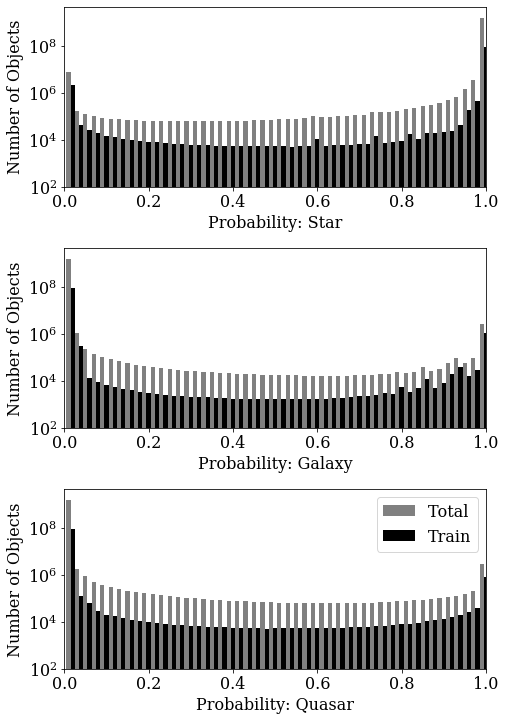

In [35]:
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(7,10))


plt.subplot(311)
plt.axis([0,1,1.0e2,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Star')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftbins[1:],totalstar,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
plt.bar(bins[1:],trainstar,color='black',width=0.01, label='Train')

# Add legend
#plt.legend(loc=2)


plt.subplot(312)
plt.axis([0,1,1.0e2,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Galaxy')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftbins[1:],totalgalaxy,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
plt.bar(bins[1:],traingalaxy,color='black',width=0.01, label='Train')

# Add legend
#plt.legend(loc=2)

plt.subplot(313)
plt.axis([0,1,1.0e2,5.0e9])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Quasar')
plt.ylabel(r'Number of Objects')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
plt.bar(leftbins[1:],totalquasar,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
plt.bar(bins[1:],trainquasar,color='black',width=0.01, label='Train')

# Add legend
plt.legend(loc=1)


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("histo_gaia_star_selection.pdf")

plt.show()


## Balanced vs. Imbalanced SubSampling for Star Prob Label

#### Cumulative Distribution of Star_Prob

In [36]:
rawcumtotal = np.cumsum(totalstar)

In [37]:
cumtotal = rawcumtotal/rawcumtotal[-1]

In [38]:
rawcumtotal[-2],rawcumtotal[-1]

(19518313, 1590266307)

In [39]:
rawcumtotal

array([   8128952,    8308957,    8436079,    8540163,    8630474,
          8711792,    8787666,    8859539,    8928473,    8995165,
          9060282,    9123806,    9186455,    9248868,    9310896,
          9373096,    9435288,    9497897,    9561303,    9625801,
          9691237,    9757750,    9826392,    9896062,    9967903,
         10042383,   10119206,   10198452,   10281644,   10385984,
         10478695,   10575140,   10676095,   10783359,   10897087,
         11018688,   11170535,   11319114,   11478481,   11652284,
         11870807,   12095265,   12374439,   12696901,   13088057,
         13579075,   14273069,   15798668,   19518313, 1590266307])

In [40]:
rawcumtrain = np.cumsum(trainstar)

In [41]:
cumtrain = rawcumtrain/rawcumtrain[-1]

In [42]:
rawcumtrain

array([ 2310099,  2354046,  2380403,  2399711,  2415101,  2428020,
        2439203,  2449330,  2458463,  2466786,  2474581,  2481895,
        2488709,  2495356,  2501605,  2507792,  2513722,  2519383,
        2524948,  2530392,  2535938,  2541248,  2546736,  2552192,
        2557522,  2563033,  2568231,  2573862,  2579257,  2590464,
        2596123,  2601887,  2607877,  2614144,  2620698,  2627466,
        2642032,  2649728,  2657945,  2666761,  2684264,  2695036,
        2714059,  2734573,  2756639,  2781837,  2823224,  3003911,
        3453912, 97499546])

In [43]:
rawcumtrain[-2],rawcumtrain[-1]

(3453912, 97499546)

#### Bias and Imbalance

In [44]:
trainbias = np.double(totalstar)/np.double(trainstar)
print(trainbias)

[ 3.51887603  4.09595649  4.82308305  5.39071887  5.86816114  6.29445003
  6.78476259  7.09716599  7.54779372  8.01297609  8.35368826  8.68526114
  9.19415908  9.38964947  9.92606817 10.05333764 10.48768971 11.05970677
 11.39371069 11.84753857 11.79877389 12.5259887  12.50765306 12.76942815
 13.47861163 13.5147886  14.77933821 14.0731664  15.42020389  9.31025252
 16.38292985 16.73230396 16.85392321 17.11568534 17.35245652 17.96705083
 10.42475628 19.30600312 19.39479129 19.71449637 12.4848883  20.83717044
 14.67560322 15.71911865 17.72663827 19.48638781 16.76840554  8.44332464
  8.26585941 16.70197677]


In [45]:
np.argmin(trainstar),trainstar[np.argmin(trainstar)]

(26, 5198)

In [46]:
bins[np.argmin(trainstar)],bins[np.argmin(trainstar)+1],bins[0],bins[-1]

(0.52, 0.54, 0.0, 1.0)

In [47]:
trainbinbias = np.double(trainstar)/5198
print(trainbinbias)

[4.44420739e+02 8.45459792e+00 5.07060408e+00 3.71450558e+00
 2.96075414e+00 2.48537899e+00 2.15140439e+00 1.94824933e+00
 1.75702193e+00 1.60119277e+00 1.49961524e+00 1.40707965e+00
 1.31088880e+00 1.27876106e+00 1.20219315e+00 1.19026549e+00
 1.14082339e+00 1.08907272e+00 1.07060408e+00 1.04732589e+00
 1.06694883e+00 1.02154675e+00 1.05579069e+00 1.04963447e+00
 1.02539438e+00 1.06021547e+00 1.00000000e+00 1.08330127e+00
 1.03789919e+00 2.15602155e+00 1.08868796e+00 1.10888803e+00
 1.15236629e+00 1.20565602e+00 1.26086957e+00 1.30203925e+00
 2.80223163e+00 1.48056945e+00 1.58080031e+00 1.69603694e+00
 3.36725664e+00 2.07233551e+00 3.65967680e+00 3.94651789e+00
 4.24509427e+00 4.84763371e+00 7.96210081e+00 3.47608696e+01
 8.65719508e+01 1.80926576e+04]


In [48]:
%%time
count_tr95 = np.double(\
               traindf.filter(F.col('gaia_classprob_dsc_combmod_star') < 0.95).count() \
                      )

CPU times: user 1.1 ms, sys: 0 ns, total: 1.1 ms
Wall time: 788 ms


In [49]:
%%time
count_tt95 = np.double(gdf.filter(F.col('classprob_dsc_combmod_star') < 0.95).count())

CPU times: user 1.22 ms, sys: 0 ns, total: 1.22 ms
Wall time: 1.26 s


In [50]:
print([count_tr95,count_tt95])

[2867072, 14839895]


In [67]:
print([2867072/97499546,14839895/1590266307.0])

[0.0294060035930834, 0.009331704340762343]


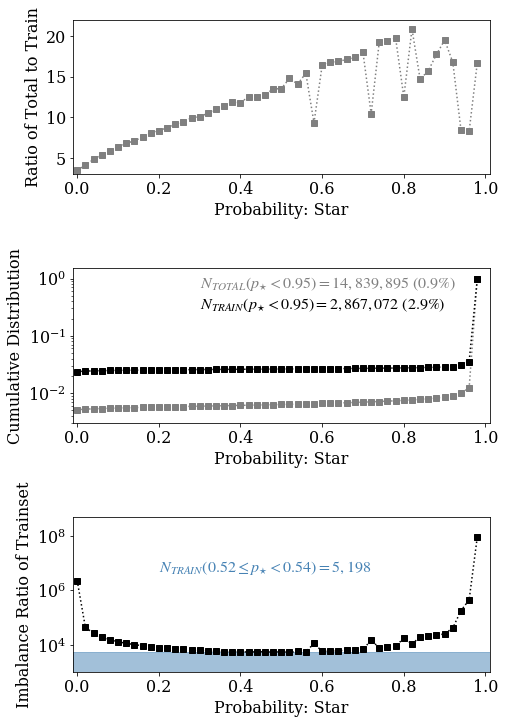

In [68]:
#plot settings
plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure(figsize=(7,10))




plt.subplot(311)
plt.axis([-0.01,1.01,3,22])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Star')
plt.ylabel(r'Ratio of Total to Train')
#plt.yscale('log')
#plt.scatter(bins[:-1],trainbias,color='gray', marker='s')
plt.plot(bins[:-1],trainbias,color='gray',linestyle=':', marker='s')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
#plt.bar(leftbins[1:],totalstar,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
#plt.bar(bins[1:],trainstar,color='black',width=0.01, label='Train')

# Add legend
#plt.legend(loc=2)



plt.subplot(312)
plt.axis([-0.01,1.01,0.003,1.5])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Star')
plt.ylabel(r'Cumulative Distribution')
plt.yscale('log')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
#plt.scatter(bins[:-1],cumtotal,color='gray', marker='s',label='Total')
plt.plot(bins[:-1],cumtotal,color='gray',marker='s',linestyle=':',label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
#plt.scatter(bins[:-1],cumtrain,color='black', marker='s',label='Train')
plt.plot(bins[:-1],cumtrain,color='black',marker='s',linestyle=':',label='Train')
plt.text(0.3,0.7,r'$N_{TOTAL}(p_{\star}<0.95) = 14,839,895 ~(0.9\%)$',color='gray')
plt.text(0.3,0.3,r'$N_{TRAIN}(p_{\star}<0.95) = 2,867,072 ~(2.9\%)$',color='black')


xlowzone = np.arange(20)/10.0 - 0.5
lowzone = np.full(len(xlowzone), 5189)
y_threshold = 1

plt.subplot(313)
plt.axis([-0.01,1.01,1000,5.0e8])
#plt.axes().set_aspect('equal', 'datalim')
#plt.title(r'Gaia_G ')
plt.xlabel(r'Probability: Star')
plt.ylabel(r'Imbalance Ratio of Trainset')
plt.yscale('log')
#plt.scatter(bins[:-1],trainbinbias,color='black', marker='s')
plt.plot(bins[:-1],np.double(trainstar),color='black',linestyle=':',marker='s')
plt.text(0.2,5000000,r'$N_{TRAIN}(0.52 \leq p_{\star} < 0.54) = 5,198 $',color='steelblue')
#plt.scatter(slicedf.px.values,slicedf.py.values,marker=".",s=1.0,color='grey')
#plt.bar(leftbins[1:],totalstar,color='grey',width=0.01, label='Total')
#plt.bar(leftgbins[1:],gtraincounts,color='grey',width=400, label='Total')
#plt.bar(bins[1:],trainstar,color='black',width=0.01, label='Train')
plt.fill_between(xlowzone, lowzone, y_threshold, where=(lowzone > y_threshold), \
                 color='steelblue', alpha=0.5)


# Add legend
#plt.legend(loc=2)




plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
fig.savefig("histo_gaia_star_trainset_bias.pdf")

plt.show()

- Total : Gaia Full Catalog. Hence, biased (outnumbered) stellar objects than other catalogs, such as PanStarrs and Legacy Surveys (middle panel)
- Imbalanced Trainset : our trainset is an intersection of all major catalogs. Hence, this imbalance is due to the full survey catalogs, themselves, i.e., even PanStarss and Legacy Survey, they have more stellar objects than the others. 

In [52]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

### Balanced Training Subset for Regression

In [53]:
traindf = \
traindf.withColumn('prob_bin', \
   F.floor(F.col('gaia_classprob_dsc_combmod_star')*49.99999999).cast(T.ShortType()))

In [54]:
traindf.select(['gaia_classprob_dsc_combmod_star','prob_bin']).show(10)

+-------------------------------+--------+
|gaia_classprob_dsc_combmod_star|prob_bin|
+-------------------------------+--------+
|                     0.99944246|      49|
|                     0.99979013|      49|
|                      0.9999586|      49|
|                     0.99997395|      49|
|                      0.9999466|      49|
|                      0.9999838|      49|
|                     0.99998707|      49|
|                     0.99664587|      49|
|                   6.2759254E-6|       0|
|                     0.99995863|      49|
+-------------------------------+--------+
only showing top 10 rows



In [55]:
traindf.select(selcols+['prob_bin']).dtypes

[('Gaia_DR3_source_id', 'bigint'),
 ('SPHERExRefID', 'bigint'),
 ('ra', 'double'),
 ('dec', 'double'),
 ('ra_error', 'double'),
 ('dec_error', 'double'),
 ('MatchingFlag', 'smallint'),
 ('gaia_ra', 'double'),
 ('gaia_dec', 'double'),
 ('gaia_classprob_dsc_combmod_star', 'float'),
 ('LS_g', 'double'),
 ('LS_r', 'double'),
 ('LS_z', 'double'),
 ('LS_g_error', 'double'),
 ('LS_r_error', 'double'),
 ('LS_z_error', 'double'),
 ('PS1_g', 'double'),
 ('PS1_r', 'double'),
 ('PS1_i', 'double'),
 ('PS1_z', 'double'),
 ('PS1_y', 'double'),
 ('PS1_g_error', 'double'),
 ('PS1_r_error', 'double'),
 ('PS1_i_error', 'double'),
 ('PS1_z_error', 'double'),
 ('PS1_y_error', 'double'),
 ('WISE_W1', 'double'),
 ('WISE_W2', 'double'),
 ('WISE_W1_error', 'double'),
 ('WISE_W2_error', 'double'),
 ('prob_bin', 'smallint')]

In [56]:
subtrdf = traindf.select(selcols+['prob_bin'])

In [57]:
subtrdf.cache()

DataFrame[Gaia_DR3_source_id: bigint, SPHERExRefID: bigint, ra: double, dec: double, ra_error: double, dec_error: double, MatchingFlag: smallint, gaia_ra: double, gaia_dec: double, gaia_classprob_dsc_combmod_star: float, LS_g: double, LS_r: double, LS_z: double, LS_g_error: double, LS_r_error: double, LS_z_error: double, PS1_g: double, PS1_r: double, PS1_i: double, PS1_z: double, PS1_y: double, PS1_g_error: double, PS1_r_error: double, PS1_i_error: double, PS1_z_error: double, PS1_y_error: double, WISE_W1: double, WISE_W2: double, WISE_W1_error: double, WISE_W2_error: double, prob_bin: smallint]

In [58]:
subtrdf.dtypes

[('Gaia_DR3_source_id', 'bigint'),
 ('SPHERExRefID', 'bigint'),
 ('ra', 'double'),
 ('dec', 'double'),
 ('ra_error', 'double'),
 ('dec_error', 'double'),
 ('MatchingFlag', 'smallint'),
 ('gaia_ra', 'double'),
 ('gaia_dec', 'double'),
 ('gaia_classprob_dsc_combmod_star', 'float'),
 ('LS_g', 'double'),
 ('LS_r', 'double'),
 ('LS_z', 'double'),
 ('LS_g_error', 'double'),
 ('LS_r_error', 'double'),
 ('LS_z_error', 'double'),
 ('PS1_g', 'double'),
 ('PS1_r', 'double'),
 ('PS1_i', 'double'),
 ('PS1_z', 'double'),
 ('PS1_y', 'double'),
 ('PS1_g_error', 'double'),
 ('PS1_r_error', 'double'),
 ('PS1_i_error', 'double'),
 ('PS1_z_error', 'double'),
 ('PS1_y_error', 'double'),
 ('WISE_W1', 'double'),
 ('WISE_W2', 'double'),
 ('WISE_W1_error', 'double'),
 ('WISE_W2_error', 'double'),
 ('prob_bin', 'smallint')]

In [59]:
!pwd

/home/shong/work/deeplearnings/star-classification/notebook


In [60]:
#rseed = 13
#rseed = 29
#rseed = 37
#rseed = 43
#rseed = 59
#rseed = 907
#rseed = 919
#rseed = 929
#rseed = 937
#rseed = 947
rseed = 953

In [61]:
# Define a window specification 
# by partitioning on 'prob_bin' and ordering by a random column

from pyspark.sql.window import Window

window_spec = Window.partitionBy('prob_bin').orderBy(F.rand(rseed))

In [62]:
subtr_rownum = subtrdf.withColumn('row_number', F.row_number().over(window_spec))

In [63]:
# Filter the DataFrame to get the first 5000 rows of each group
sampled_df = subtr_rownum.filter(F.col('row_number') <= 5000).drop('row_number')

In [64]:
# Show the sampled DataFrame
#sampled_df.count()

In [65]:
%%time
trpdf = sampled_df.toPandas()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/sql/pandas/conversion.py", line 355, in _collect_as_arrow
    results = list(batch_stream)
  File "/usr/local/spark/python/pyspark/sql/pandas/serializers.py", line 53, in load_stream
    for batch in self.serializer.load_stream(stream):
  File "/usr/local/spark/python/pyspark/sql/pandas/serializers.py", line 96, in load_stream
    for batch in reader:
  File "pyarrow/ipc.pxi", line 638, in pyarrow.lib.RecordBatchReader.__iter__
  File "pyarrow/ipc.pxi", line 674, in pyarrow.lib.RecordBatchReader.read_next_batch
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.sen

KeyboardInterrupt: 

In [66]:
trpdf.info()

NameError: name 'trpdf' is not defined

In [ ]:
trpdf['prob_bin'].value_counts()

In [ ]:
trpdf[['Gaia_DR3_source_id','gaia_classprob_dsc_combmod_star','prob_bin']].tail()

In [ ]:
trpdf.info()

In [ ]:
localdatapath

In [ ]:
trpdf.to_parquet(localdatapath+'train-balanced-regressor-t953.pandas.parquet')

In [ ]:
!ls {localdatapath}

In [ ]:
trpdf.head(3).transpose()